In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)
import os
root_path = 'gdrive/My Drive/EACL/'
os.chdir(root_path)

Mounted at /content/gdrive


In [2]:
!pip install transformers
!pip install demoji

     |████████████████████████████████| 1.5MB 9.5MB/s 
     |████████████████████████████████| 2.9MB 45.3MB/s 
     |████████████████████████████████| 890kB 44.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=6e7be88bec7d47d8a09faa7bbb444de89165619d767b7cb37a51dd7a7fb7d347
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [6]:
import numpy as np
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification
import torch
import copy
from transformers import BertModel, RobertaModel, BertTokenizer, RobertaTokenizer, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, RandomSampler, SequentialSampler, random_split, DataLoader, IterableDataset, ConcatDataset
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score 
from tqdm import tqdm
import demoji 
import random
demoji.download_codes() 
plt.rcParams['figure.figsize'] = [15, 8]
plt.rcParams.update({'font.size': 8})
RANDOM_SEED = 42
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

... OK (Got response in 0.19 seconds)
Writing emoji data to /root/.demoji/codes.json ...
... OK


In [7]:
def random_seed(seed_value, use_cuda):
    np.random.seed(seed_value)  
    torch.manual_seed(seed_value)  
    random.seed(seed_value)
    if use_cuda:
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)  
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
random_seed(RANDOM_SEED, True)

In [14]:
class Dataset():
    def __init__(self, train_data, val_data, batch_size = 32):
        self.train_data = train_data
        self.val_data = val_data
        self.batch_size = batch_size

        self.label_dict = {'Not_offensive': 0,
                            'Offensive_Targeted_Insult_Group': 3,
                            'Offensive_Targeted_Insult_Individual': 5,
                            'Offensive_Targeted_Insult_Other': 2,
                            'Offensive_Untargetede': 4,
                            'not-malayalam': 1}
                                    
        self.count_dic = {}

        self.train_inputs, self.train_labels = self.process_data(self.train_data)
        self.val_inputs, self.val_labels = self.process_data(self.val_data)

        self.train_dataloader = self.get_dataloader(self.train_inputs, self.train_labels)
        self.val_dataloader = self.get_dataloader(self.val_inputs, self. val_labels, train = False)

    def tokenize(self, sentences, padding = True, max_len = 256):
        tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
        input_ids, attention_masks = [], []
        for sent in sentences:
            encoded_dict = tokenizer.encode_plus(sent,
                                                    add_special_tokens=True,
                                                    max_length=max_len, 
                                                    padding='max_length', 
                                                    return_attention_mask = True,
                                                    return_tensors = 'pt', 
                                                    truncation = True)
            input_ids.append(encoded_dict['input_ids'])
            attention_masks.append(encoded_dict['attention_mask'])
        
        input_ids = torch.cat(input_ids, dim=0)
        attention_masks = torch.cat(attention_masks, dim=0)

        return {'input_ids': input_ids, 'attention_masks': attention_masks}
    
    def process_data(self, data):
        sentences, labels = [], []
        print(len(data))
        for line in data:
            sentence = line.strip().split('\t')
            label = sentence.pop()
            if label not in self.label_dict:
                self.label_dict[label] = len(self.label_dict)
            sentence = ' '.join(sentence)
            emoji_dict = demoji.findall(sentence)
            if len(emoji_dict): 
                for emoji, text in emoji_dict.items():
                    sentence = sentence.replace(emoji, ' '+text+' ')
                    sentence = ' '.join(sentence.split())
            sentences.append(sentence)
            labels.append(self.label_dict[label])
            self.count_dic[label] = self.count_dic.get(label, 0) + 1
        inputs = self.tokenize(sentences)

        return inputs, torch.Tensor(labels)
    
    def get_dataloader(self, inputs, labels, train = True):
        data = TensorDataset(inputs['input_ids'], inputs['attention_masks'], labels)
        if train:
            sampler = RandomSampler(data)
        else:
            sampler = SequentialSampler(data)
        return DataLoader(data, sampler=sampler, batch_size=self.batch_size)

In [17]:
with open('Dataset/kannada_offensive_train.csv', 'r') as f:
    train_data = f.readlines()
with open('Dataset/mal_full_offensive_dev.csv', 'r') as f:
    val_data = f.readlines()
data = Dataset(train_data, val_data)

6217
1999


In [18]:
data.label_dict

{'Not_offensive': 0,
 'Offensive_Targeted_Insult_Group': 3,
 'Offensive_Targeted_Insult_Individual': 5,
 'Offensive_Targeted_Insult_Other': 2,
 'Offensive_Untargetede': 4,
 'not-Kannada': 6,
 'not-malayalam': 1}

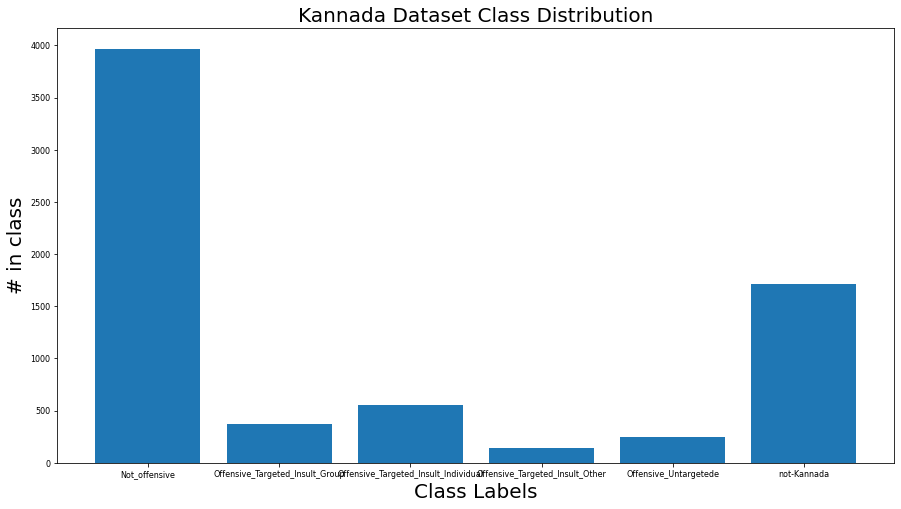

In [ ]:
labels = ['Not_offensive',
                    'Offensive_Targeted_Insult_Group',
                    'Offensive_Targeted_Insult_Individual',
                    'Offensive_Targeted_Insult_Other',
                    'Offensive_Untargetede',
                    'not-Kannada']
counts = [data.count_dic.get(label, 0) for label in labels]
plt.bar(labels, counts)
plt.ylabel('# in class', fontsize = 20)
plt.xlabel('Class Labels', fontsize = 20)
plt.title('Kannada Dataset Class Distribution', fontsize = 20)
plt.show()

In [ ]:
# Save and Load Functions
def save_metrics(save_path, epochs, model, optimizer, F1):

    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'epochs': epochs+1,
                  'F1': F1}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path, model, optimizer):
    try: 
        state_dict = torch.load(load_path, map_location=device)
        model.load_state_dict(state_dict['model_state_dict'])
        optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    except: 
        state_dict = {}

    print(f'Model loaded from <== {load_path}')
    
    return state_dict.get('epochs', 0), state_dict.get('F1', 0)

In [ ]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)
 
def get_predicted(preds):
    pred_flat = np.argmax(preds, axis=1).flatten()
    return pred_flat
 
def evaluate(test_dataloader, model):
    model.eval()
    y_preds, y_test = np.array([]), np.array([])

    for batch in test_dataloader:
        b_input_ids, b_input_mask, b_labels = batch[0].to(device), batch[1].to(device), batch[2].to(device).long()
        with torch.no_grad():        
            outputs = model(input_ids = b_input_ids, attention_mask = b_input_mask, labels=b_labels)
        _, ypred = outputs.loss, outputs.logits
        ypred = ypred.cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        y_preds = np.hstack((y_preds, get_predicted(ypred)))
        y_test = np.hstack((y_test, label_ids))

    weighted_f1 = f1_score(y_test, y_preds, average='weighted')
    return weighted_f1, y_preds, y_test
 
def train(training_dataloader, validation_dataloader, model, filepath, learning_rate = 2e-5, epochs = 4, print_every = 10):
    total_steps = len(training_dataloader) * epochs
    optimizer = AdamW(model.parameters(), lr=learning_rate, eps = 1e-8)
    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                num_warmup_steps = 0, # Default value in run_glue.py
                                                num_training_steps = total_steps)
    
    current_epoch, best_weighted_f1 = load_metrics(filepath, model, optimizer)
    for epoch_i in tqdm(range(current_epoch, epochs)):
        model.train()
        for step, batch in enumerate(training_dataloader):
            b_input_ids, b_input_mask, b_labels = batch[0].to(device), batch[1].to(device), batch[2].to(device).long()
            
            outputs = model(input_ids = b_input_ids, attention_mask = b_input_mask, labels=b_labels)
            loss, ypred = outputs.loss, outputs.logits
 
            if step%print_every == 0:
                print(loss.item())
 
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
 
        print('### Validation Set Stats')
        weighted_f1, ypred, ytest = evaluate(validation_dataloader, model)
        print("  Weighted F1: {0:.2f}".format(weighted_f1))
        if weighted_f1 > best_weighted_f1:
            best_weighted_f1 = weighted_f1
            save_metrics(filepath, epoch_i, model, optimizer, weighted_f1)

In [ ]:
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels = 6).to(device)
optimizer = AdamW(model.parameters(), lr=2e-5, eps = 1e-8)
load_metrics('combined_mal.pt', model, optimizer)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

Model loaded from <== combined_mal.pt


(4, 0.9656997707887638)

In [ ]:
_, ypred, ytest = evaluate(data.val_dataloader, model)
from sklearn.metrics import confusion_matrix
array = confusion_matrix(ytest, ypred)

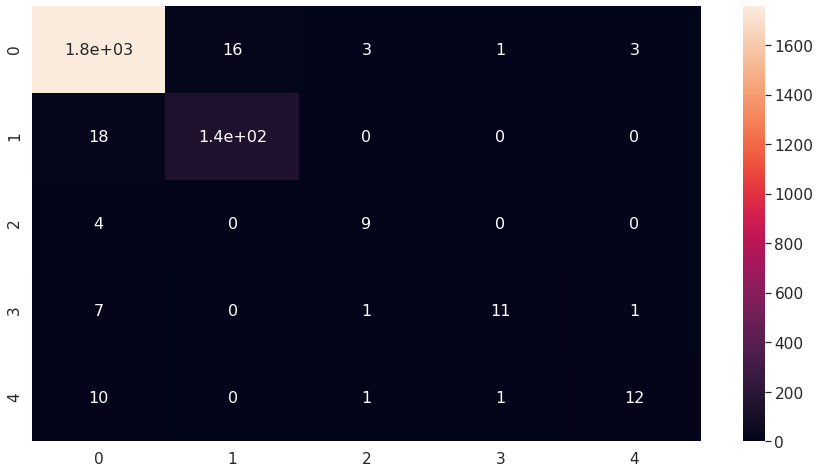

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(array, range(5), range(5))
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()

In [ ]:
train(data.train_dataloader, data.val_dataloader, model, 'tamil_mal.pt')